In [1]:
!pip install stable-baselines3

     |████████████████████████████████| 176 kB 5.1 MB/s 


In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib
from matplotlib import pyplot as plt
import gym
from gym.spaces import Box, Discrete
from stable_baselines3.common.evaluation import evaluate_policy
from sklearn.preprocessing import MinMaxScaler

In [3]:
# data = pd.read_csv('/content/drive/MyDrive/Capstone/Workspace/stock-market-reinforcement-learning/stock-price-predictor/data/NFLX.csv')
data = pd.read_csv('NFLX.csv')
data.head()

Date      Open      High       Low     Close  Adj. Close    Volume
0  2010-01-04  7.931429  7.961429  7.565714  7.640000    7.640000  17239600
1  2010-01-05  7.652857  7.657143  7.258571  7.358571    7.358571  23753100
2  2010-01-06  7.361429  7.672857  7.197143  7.617143    7.617143  23290400
3  2010-01-07  7.731429  7.757143  7.462857  7.485714    7.485714   9955400
4  2010-01-08  7.498571  7.742857  7.465714  7.614286    7.614286   8180900

In [4]:
class StockEnv(gym.Env):
    
    # Constructor
    def __init__(self, data, state_length, investment):
        '''
        INPUTS:
        - data [DataFrame]: the dataframe of the stock (from Yahool Finance).
        - state_length [int]: the size of state (trading timeframe) provided to the agent.
        - investment [int]: the investment agent is given.
        '''
        # State attributes
        self.data = data
        self.scaler = MinMaxScaler(feature_range=(0,1))
        self.state_length = state_length

        self.done = False # Whether there is more state
        self.t = self.state_length # Current date where the agent is at
        self.ACTION_SPACE_SIZE = 2 # 2 actions avaliable
        self.price_prediction_cols = ['Predict1', 'Predict2', 'Predict3', 'Predict4', 'Predict5']

        self.__format_state()
        
        # Agent attributes
        self.wallet_init = investment # For resetting
        self.wallet = investment # For making updates
        self.portfolio = 0 # Stock owned by agent
        self.history = {'Buy': [[],[]], 'Sell': [[],[]]} # Saves the trading history. The list[0] stores the date, list[1] stores the price
        self.action_space = Discrete(2)
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(state_length+5,1), dtype=np.float32)
    
    def __format_state(self):
        state = self.data[self.t - self.state_length : self.t].Open
        #prediction = self.data[self.price_prediction_cols].iloc[self.t].values
        prediction = np.array([1,1,1,1,1])
        state = np.concatenate((state, prediction))
        state = np.array(state).reshape((self.state_length+5,1))
        self.state = self.scaler.fit_transform(state)
        
    def step(self, action, deploy=False):
        '''
        INPUTS:
        - action [int]: the action took by the agent. 
            - action = 0: buy
            - action = 1: sell
        OUTPUTS:
        - state: the new state of the agent (one day foward)
        - reward: the reward of the action
        - done: whether the game is over
        - info: provides info of the state ('wallet' ,'portfolio','current day')
        '''
        
        # Check if the agent can buy any stock
        # Returns: Boolean. True if can buy, False if not
        def can_buy(self):
            if self.wallet >= self.data.iloc[self.t].Open:
                return True
            else:
                return False
    
        # Check if the agent can sell any stock
        # Returns: Boolean. True if can sell, False if not
        def can_sell(self):
            if self.portfolio > 0:
                return True
            else:
                return False
        
        # Increment state by 1 step (foward 1 day)
        def step_state(self):
            self.t += 1
            if self.t == self.data.shape[0]-1: # No more data
                self.done = True
            '''
            state = self.data[self.t - self.state_length : self.t].Open
            state = np.array(state).reshape((self.state_length,1))
            self.state = self.scaler.fit_transform(state)
            '''
            self.__format_state()
            
        # Computes the total balance: wallet + holdings
        def total_balance(self, price):
            '''
            INPUTS:
            - price [int]: price of 1 stock
            '''
            #current_price = self.data.iloc[0].Open # Price of 1 stock
            return self.wallet + price*self.portfolio
        
        reward = 0 # initialize reward
        price_t1 = self.data.iloc[self.t].Open # Today's price
        date = self.data.iloc[self.t].Date
        step_state(self) # Proceed to next state
        price_t2 = self.data.iloc[self.t].Open # Tomorrow's price
        
        if action == 0 and can_buy(self): # buy stock
            self.wallet -= price_t1
            self.portfolio += 1
            # reward is the regret
            reward = 100*(price_t2 - price_t1) / price_t1
            self.history['Buy'][0].append(date)
            self.history['Buy'][1].append(price_t1)
        elif action == 1 and can_sell(self): # sell stock
            self.wallet += price_t1
            self.portfolio -= 1
            # reward is the opportunity cost
            reward = 100*(price_t1 - price_t2) / price_t1
            self.history['Sell'][0].append(date)
            self.history['Sell'][1].append(price_t1)
        else: # hold stock
            reward = 0
            
        net_worth = total_balance(self, price_t1)
        if net_worth < 0.90*self.wallet_init or self.t >= len(data)-2:
            self.done = True
        else:
            self.done = False
        
        info = {'net worth': net_worth,
                'wallet': self.wallet, 
                'portfolio': self.portfolio,
                'current day': self.t,
                'reward': reward}
        
        return self.state, reward, self.done, info
    
    # Reset the environment.
    def reset(self, random_day=False):
        # Reset state attributes
        if random_day == False:
            self.t = self.state_length
        else: # reset on a random day
            day = np.random.randint(self.state_length,len(self.data))
            self.t = day
        self.__format_state()

        self.done = False
            
        # Reset agent attributes
        self.wallet = self.wallet_init
        self.portfolio = 0
        return self.state
    
    def render(self, mode='console'):
        price = self.data.iloc[self.t].Open
        networth = self.wallet + price*self.portfolio
        print('Day: {}, Networth: {}, Wallet: {}, Portfolio: {}'.format(self.t, networth, self.wallet, self.portfolio))

In [5]:
test = [[7.6225], [7.664286], [7.656429], [7.5625], [7.510714]]
test = np.array(test)
scaler = MinMaxScaler(feature_range=(0,1))
print(scaler.fit_transform(test))


[[0.72790613]
 [1.        ]
 [0.94883833]
 [0.33720991]
 [0.        ]]


In [6]:
from stable_baselines3.common.env_checker import check_env

env = StockEnv(data, state_length=50, investment=1000)
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/env_checker.py:131: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  f"Your observation {key} has an unconventional shape (neither an image, nor a 1D vector). "


In [7]:
episodes = 10

for episode in range(1, episodes + 1):
  state = env.reset()
  done = False
  score = 0

  while not done:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    score += reward
  print('Episode: {} Score: {}'.format(episode, score))

Episode: 1 Score: -56.14058444140976
Episode: 2 Score: -205.12406798432116
Episode: 3 Score: 157.13528240998278
Episode: 4 Score: 3.5121482884084605
Episode: 5 Score: 4.160507258362871
Episode: 6 Score: 195.50131876685464
Episode: 7 Score: -69.62548400296076
Episode: 8 Score: 8.967011021859353
Episode: 9 Score: -28.78518272387857
Episode: 10 Score: 393.01066520968936


In [9]:
%%time 

from stable_baselines3 import DQN

model = DQN("MlpPolicy", env, verbose = 1)
model.learn(total_timesteps = 100000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.73e+03 |
|    ep_rew_mean      | 37.8     |
|    exploration_rate | 0.343    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 687      |
|    time_elapsed     | 10       |
|    total_timesteps  | 6919     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.09e+03 |
|    ep_rew_mean      | 28.9     |
|    exploration_rate | 0.175    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 689      |
|    time_elapsed     | 12       |
|    total_timesteps  | 8689     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1.29e+03 |
|    ep_rew_mean      | -3.35 

In [12]:
%%time 

def calc_sharpe(networth):
  df = pd.Series(networth, name="nw").to_frame()

  df['daily_return'] = df['nw'].pct_change(1)
  sharpe = (30 ** 0.5) * df['daily_return'].mean() / df['daily_return'].std()

  return sharpe

def get_sharpe(model, env):
  """
    Calculate Maximum Drawdown 
  """
  net_worth = []

  def eva_callback(local_var, global_var):
    net_worth.append(local_var["info"]["net worth"])
  evaluate_policy(model, env, callback = eva_callback, n_eval_episodes=1)

  sharpe = calc_sharpe(net_worth)

  return sharpe

sharpe = get_sharpe(model, env)

print(f"The Sharpe Ratio is {sharpe:.4f} ")

/usr/local/lib/python3.7/dist-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


The Sharpe Ratio is 0.0261 
CPU times: user 1.04 s, sys: 8.92 ms, total: 1.04 s
Wall time: 1.04 s


In [13]:
%%time

def plotTradeHistory(data, buy_history, sell_history, start, end):
    date = list(data['Date'].values)
    price = list(data['Open'].values)
    start_index = None
    end_index = None
    for i, date in enumerate(date):
        if date == start:
            start_index = i
        if date == end:
            end_index = i
    data = data.iloc[start_index:end_index+1]

    start_index_buy = 0
    end_index_buy = 0
    while buy_history[0][start_index_buy] < start:
        start_index_buy += 1
    start_index_buy -= 1
    while buy_history[0][end_index_buy] < end:
        end_index_buy += 1
    end_index_buy += 1
    buy_history_date = buy_history[0][start_index_buy:end_index_buy+1]
    buy_history_price = buy_history[1][start_index_buy:end_index_buy+1]

    start_index_sell = 0
    end_index_sell = 0
    while sell_history[0][start_index_sell] < start:
        start_index_sell += 1
    start_index_sell -= 1
    while sell_history[0][end_index_sell] < end:
        end_index_sell += 1
    end_index_sell += 1
    sell_history_date = sell_history[0][start_index_sell:end_index_sell+1]
    print(sell_history_date)
    sell_history_price = sell_history[1][start_index_sell:end_index_sell+1]

    plt.figure(figsize=(15,10))
    plt.plot(data['Date'], data['Open'])
    plt.scatter(buy_history_date, buy_history_price, marker='o', label='Buy', c='green')
    plt.scatter(sell_history_date, sell_history_price, marker='x', label='Sell', c='red')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Buy and Sell for AAPL')
    plt.legend()
    plt.show()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


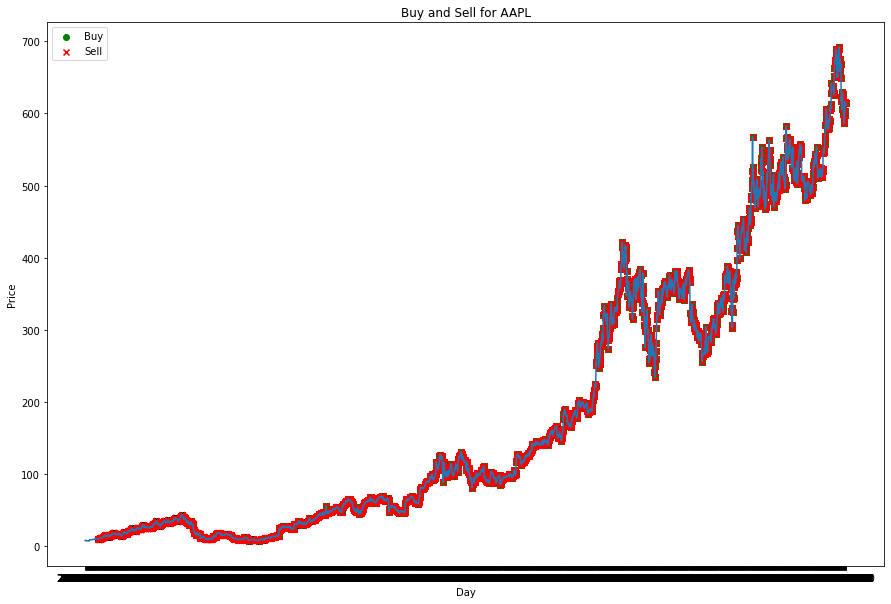

In [14]:
plt.figure(figsize=(15,10))
plt.plot(data['Date'], data['Open'])
buy_history = env.history['Buy'] # [[date ...],[price ...]]
sell_history = env.history['Sell'] # [[date ...],[price ...]]
plt.scatter(buy_history[0], buy_history[1], marker='o', label='Buy', c='green')
plt.scatter(sell_history[0], sell_history[1], marker='x', label='Sell', c='red')
plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Buy and Sell for AAPL')
plt.legend()
plt.show()

In [ ]:
plotTradeHistory(data, buy_history, sell_history, '2020-07-14', '2021-03-10')